# Abalone P.I - Análisis exploratorio de datos

En esta notebook se presenta la primera parte de un trabajo integral que incluye el análisis de datos, su preprocesamiento, y el entrenamiento, proceso de selección de modelos y prueba a través de un algoritmo de clustering. En este se analiza un dataset que contiene datos relativos al sexo, dimensiones y peso de especímenes de orejas de mar.

En esta primer parte, se realiza la obtención, análisis de los datos y preprocesamiento de los datos.

# 1 - Obtención de los datos


El dataset elegido es el de <i>[Abalone](https://github.com/ignaciorlando/duia-ml-datasets/tree/master/AbaloneDataset)</i>, el cual contiene datos sobre las orejas de mar (según Wikipedia).

El problema que se trata de resolver con el mismo es el de predecir su edad, a partir de atributos relacionados a su sexo, dimensiones, y peso. El atributo clase a predecir es la cantidad de anillos, dado que la edad en años se obtiene sumando 1,5 a este número.

Por lo dicho, el atributo clase es un número discreto, con lo que esto consiste en un problema de clasificación binaria. A pesar de esto, es posible encararlo como un problema de regresión, para lo cual se podría convertir al atributo clase *Rings* en edad en años, como se explica.

En primer lugar, se instalan paquetes necesarios y se crea una nueva carpeta dentro de la estructura de Google Drive, para alojar al dataset.

In [8]:
# importo numpy e indico que imprima solo 2 decimales
import numpy as np
from os import path
np.set_printoptions(precision=2, suppress=True) # imprimir solo 2 decimales

# importo biblioteca para utilizar valores aleatorios
import random
random.seed(10)
np.random.seed(10)

# apuntamos al archivo requerido
ds_folder = '../datasets/'

abalone_ds = {}
abalone_ds['filename'] = path.join(ds_folder, 'abalone.data')#'datasets/abalone.data'
abalone_ds['description'] = np.genfromtxt(path.join(ds_folder, 'readme.txt'),
                                          delimiter='\n', dtype='str', encoding='iso8859')

# imprimimos las keys de los datos cargados
#print(f'Información disponible en el archivo: {list(dataset_pkl.keys())}')

In [9]:
# Imprimimos línea por línea la descripción íncluda en el repositorio.

[line for line in abalone_ds['description']]

['The Abalone Dataset involves predicting the age of abalone given objective measures of individuals.',
 'It is a multi-class classification problem, but can also be framed as a regression. The number of observations for each class is not balanced. There are 4,177 observations with 8 input variables and 1 output variable. The variable names are as follows:',
 'Sex (M, F, I).',
 'Length.',
 'Diameter.',
 'Height.',
 'Whole weight.',
 'Shucked weight.',
 'Viscera weight.',
 'Shell weight.',
 'Rings.',
 'The baseline performance of predicting the most prevalent class is a classification accuracy of approximately 16%. The baseline performance of predicting the mean value is an RMSE of approximately 3.2 rings.']

Como vemos, todos los atributos están etiquetados, podemos dividir a los mismos en cuatro categorías:

1. **Sexo**: Única variable categórica del dataset, pudiendo ser masculino, *M*; femenino, *F*; o infante *I*.
2. **Dimensiones**: Tenemos tres atributos dimensionales, largo, diámetro y altura.
3. **Peso**: Los atributos relativos al peso son cuatro. Luego de una breve investigación online, sabemos que estos son el peso de la concha (*shell*), el de las víseras, el de todo el especímen (*whole*), y el de la carne (*shucked*).
4. **Edad**: Queda determinada por el atributo clase *Rings* más una constante de 1,5, en años.

No se detecta ninguna variable con sesgo, posteriormente se estudiarán las mismas en busqueda de datos faltantes y/o erróneos. Se crea un diccionario para almacenar ordenadamente el nombre de los atributos.

In [10]:
feature_names = dict(enumerate(abalone_ds['description'][2:-1]))
feature_names

{0: 'Sex (M, F, I).',
 1: 'Length.',
 2: 'Diameter.',
 3: 'Height.',
 4: 'Whole weight.',
 5: 'Shucked weight.',
 6: 'Viscera weight.',
 7: 'Shell weight.',
 8: 'Rings.'}

Se crea un dataset crudo a partir de los datos descargados, e incluyendo el nombre de los atributos para cada columna. Para los nombres de las columnas se eliminan las comas y puntos presentes en el diccionario.

En este paso, se convierte la variable cateegórica en formato `str` a numérica, asignando a cada uno de los tres sexos disponibles, un número del 0 al 2.

In [11]:
sex = ['M', 'F', 'I']
sex_conv_dict = dict((sex, idx) for idx, sex in enumerate(sex))

raw_ds = np.genfromtxt(abalone_ds['filename'], delimiter=',', 
    names=', '.join([values.replace(',', '').replace('.', '') for values in feature_names.values()]),
    encoding='utf-8',
    converters = {0: lambda x: sex_conv_dict.get(x, 1000)})

raw_ds

array([(0., 0.46, 0.36, 0.1 , 0.51, 0.22, 0.1 , 0.15, 15.),
       (0., 0.35, 0.27, 0.09, 0.23, 0.1 , 0.05, 0.07,  7.),
       (1., 0.53, 0.42, 0.14, 0.68, 0.26, 0.14, 0.21,  9.), ...,
       (0., 0.6 , 0.47, 0.2 , 1.18, 0.53, 0.29, 0.31,  9.),
       (1., 0.62, 0.48, 0.15, 1.09, 0.53, 0.26, 0.3 , 10.),
       (0., 0.71, 0.56, 0.2 , 1.95, 0.95, 0.38, 0.49, 12.)],
      dtype=[('Sex_M_F_I', '<f8'), ('Length', '<f8'), ('Diameter', '<f8'), ('Height', '<f8'), ('Whole_weight', '<f8'), ('Shucked_weight', '<f8'), ('Viscera_weight', '<f8'), ('Shell_weight', '<f8'), ('Rings', '<f8')])

# 2 - Análisis de datos

El dataset crudo, generado mediante la operación `genfromtxt()`, se representa en un array de tuplas. En primer lugar, se lo convierte a un arreglo de dos dimensiones, y a continuación, se obtiene de forma separada la matriz de diseño y el atributo clase.

In [6]:
mat_ds = np.zeros(shape=(len(raw_ds), len(feature_names)))
for i, row in enumerate(raw_ds):
  for j, item in enumerate(row):
    mat_ds[i,j] = item

print(f'Obtenemos una arreglo con {mat_ds.shape[0]} ejemplos y {mat_ds.shape[1]} features.')
print(f'Sus primeras 5 filas son:\n {mat_ds[:5, :]}')

# obtenemos la matriz de diseño y sus labels por separado
X, y = (mat_ds[:,:-1], mat_ds[:,-1])

Obtenemos una matriz con 4177 ejemplos y 9 features.
Sus primeras 5 filas son:
 [[ 0.    0.46  0.36  0.1   0.51  0.22  0.1   0.15 15.  ]
 [ 0.    0.35  0.27  0.09  0.23  0.1   0.05  0.07  7.  ]
 [ 1.    0.53  0.42  0.14  0.68  0.26  0.14  0.21  9.  ]
 [ 0.    0.44  0.36  0.12  0.52  0.22  0.11  0.15 10.  ]
 [ 2.    0.33  0.26  0.08  0.2   0.09  0.04  0.06  7.  ]]


Como primer paso en el análisis propio de los datos, queremos saber si existen atributos con valores faltantes en alguno de los ejemplos.

In [8]:
np.any(np.isnan(X), axis=0)

array([False, False, False, False, False, False, False, False])

La operación previa nos muestra que el dataset está completo.

Imprimimos a continuación una suerte de histograma, con la cantidad de ocurrencias por etiqueta del atributo clase (discreto).

In [9]:
label_vals, n_vals = np.unique(y, return_counts=True)
[print(f'Valor: {label_vals[i]}, Ocurrencias: {n_vals[i]}') for i in range(len(label_vals))];

Valor: 1.0, Ocurrencias: 1
Valor: 2.0, Ocurrencias: 1
Valor: 3.0, Ocurrencias: 15
Valor: 4.0, Ocurrencias: 57
Valor: 5.0, Ocurrencias: 115
Valor: 6.0, Ocurrencias: 259
Valor: 7.0, Ocurrencias: 391
Valor: 8.0, Ocurrencias: 568
Valor: 9.0, Ocurrencias: 689
Valor: 10.0, Ocurrencias: 634
Valor: 11.0, Ocurrencias: 487
Valor: 12.0, Ocurrencias: 267
Valor: 13.0, Ocurrencias: 203
Valor: 14.0, Ocurrencias: 126
Valor: 15.0, Ocurrencias: 103
Valor: 16.0, Ocurrencias: 67
Valor: 17.0, Ocurrencias: 58
Valor: 18.0, Ocurrencias: 42
Valor: 19.0, Ocurrencias: 32
Valor: 20.0, Ocurrencias: 26
Valor: 21.0, Ocurrencias: 14
Valor: 22.0, Ocurrencias: 6
Valor: 23.0, Ocurrencias: 9
Valor: 24.0, Ocurrencias: 2
Valor: 25.0, Ocurrencias: 1
Valor: 26.0, Ocurrencias: 1
Valor: 27.0, Ocurrencias: 2
Valor: 29.0, Ocurrencias: 1


Es fácil ver que varía de manera notoria la frecuencia de repetición de las etiquetas, existiendo solo un ejemplo para 5 clases distintas, y teniendo 689 ocurrencias la más representada.

A continuación, se busca obtener información básica sobre la distribución de los atributos para la matriz de diseño. Para esto, se imprimen sus valores mínimos y máximos, junto a la media y el desvío estándar para cada uno de ellos.

In [10]:
print(f'Valores máximos:  {np.max(X, axis=0)}')
print(f'Valores mínimos:  {np.min(X, axis=0)}')
print(f'Medias:           {np.mean(X, axis=0)}')
print(f'Desvíos estándar: {np.std(X, axis=0)}')

Valores máximos:  [2.   0.81 0.65 1.13 2.83 1.49 0.76 1.  ]
Valores mínimos:  [0.   0.07 0.06 0.   0.   0.   0.   0.  ]
Medias:           [0.96 0.52 0.41 0.14 0.83 0.36 0.18 0.24]
Desvíos estándar: [0.83 0.12 0.1  0.04 0.49 0.22 0.11 0.14]


Como vemos, no existen grandes variaciones en los rangos de representación numérica de los atributos.

# 3 - Partición de los datos

A continuación, se dividen los ejemplos en tres sets diferentes, a saber:
* **Test**:  se utilizará para probar al algoritmos de ML a entrenar, al ingresarle ejemplos no contemplados por el mismo en su etapa de entrenamiento. Su tamaño es de 30% el del dataset completo.
* **Train**: set mayoritario, empleado para entrenar y ajustar el algoritmo. Del 70% de datos restante, el 90% se reservan con este fin.
* **Validation**: set que se reserva para ajustes de hiperparámetros que puedan realizarse. Contiene un 10% de los ejemplos del 70% que queda luego de obtener el set de test.

Es importante para particionar que se realize una selección aleatoria de los ejemplos a incluir.

In [11]:
# calculamos la cantidad de muestras para entrenamiento, validación y prueba
n_test = round(0.3*X.shape[0])
n_val = round(0.7*0.1*X.shape[0])
n_train = X.shape[0] - n_val - n_test

# creamos una lista de índices para las instancias y la aleatorizamos
idx = list(range(0, X.shape[0]))
random.shuffle(idx)

# separamos los ejemplos en los sets de train/validation y test
X_test = X[idx[:n_test],:]
y_test = y[idx[:n_test]]
X_val = X[idx[n_test:n_test+n_val],:]
y_val = y[idx[n_test:n_test+n_val]]
X_train = X[idx[n_test+n_val:],:]
y_train = y[idx[n_test+n_val:]]

# verificamos sus tamaños
print(f'Cantidad de ejemplos por set:\n\nEntrenamiento: {X_train.shape[0]}\
  \nValidación: {X_val.shape[0]}\nPrueba: {X_test.shape[0]}')

Cantidad de ejemplos por set:

Entrenamiento: 2632  
Validación: 292
Prueba: 1253


#4 - Análisis visual de los datos

Una vez divididos los datos, haremos un breve análisis de la distribución del atributo clase para cada uno de los sets generados, a modo de observar si está correctamente representado en los sets.

Adicionalmente, queremos ver si en el set de entrenamiento se incluye al menos un ejemplo para cada etiqueta existente en el dataset. Lo que determina si el algoritmo a aplicar, se entrenará o no con la totalidad de etiquetas provistas.

Todas las etiquetas están representados en el set de entrenamiento.



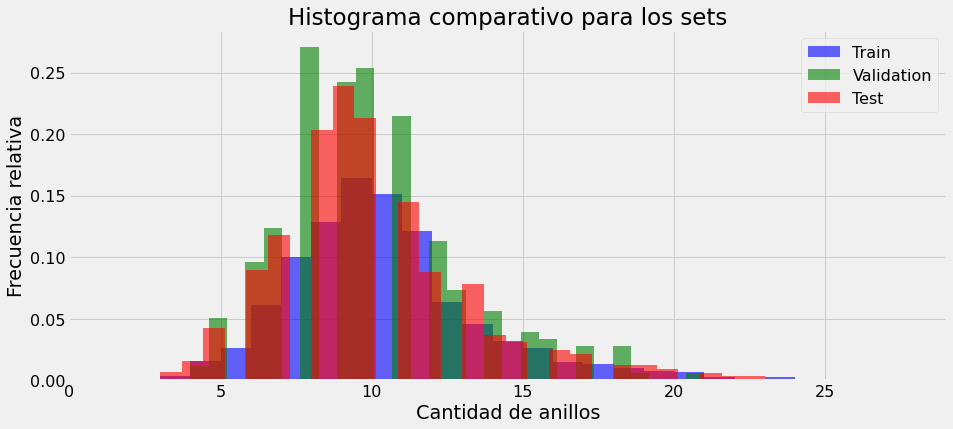

In [27]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') # cambio de estilo para tener plots claros en modo oscuro
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 16

# utilizamos la cantidad de labels vistos previamente
n_bins = len(np.unique(y))
# están todos los labels representados en el set de entrenamiento ?
all_labels_repr_train = len(np.unique(y)) == len(np.unique(y_train))
print('Todas las etiquetas están representados en el set de entrenamiento.\n') if all_labels_repr_train\
 else print('No son representadas todas las etiquetas en el set de entrenamiento.\n')

# generamos los histogramas para cada set
fig, ax = plt.subplots()
ax.hist(y_train, n_bins, label='Train', density=True, facecolor='b', alpha=0.6)
ax.hist(y_val, n_bins, label='Validation', density=True, facecolor='g', alpha=0.6)
ax.hist(y_test, n_bins, label='Test', density=True, facecolor='r', alpha=0.6)
# agregamos leyendas y etiquetas al gráfico, y ajustamos
ax.set_xlim([0, np.max(y)])
ax.set_ylabel('Frecuencia relativa')
ax.set_xlabel('Cantidad de anillos')
ax.set_title('Histograma comparativo para los sets')
#ax.set_yscale('log') # facilita ver que las etiquetas poco representadas quedan en el train set
ax.legend()
ax.grid(True)

Se puede ver que las distribuciones son aproximadamente similares, incluyendo mayor cantidad de información alrededor de los 10 anillos, para los tres sets.

A pesar de esto, se ve que hay etiquetas que no son representadas para los sets de validación y test, cumpliéndose por otro lado esta condición en el de entrenamiento. Utilizando una escala logarítimica para el eje *y*, es posible ver que las clases menos representadas se inclyen en este último set.

A continuación, centramos el análisis en el set de entrenamiento. En primer lugar, observaremos el histograma de cada uno de los atributos de la matriz de diseño.

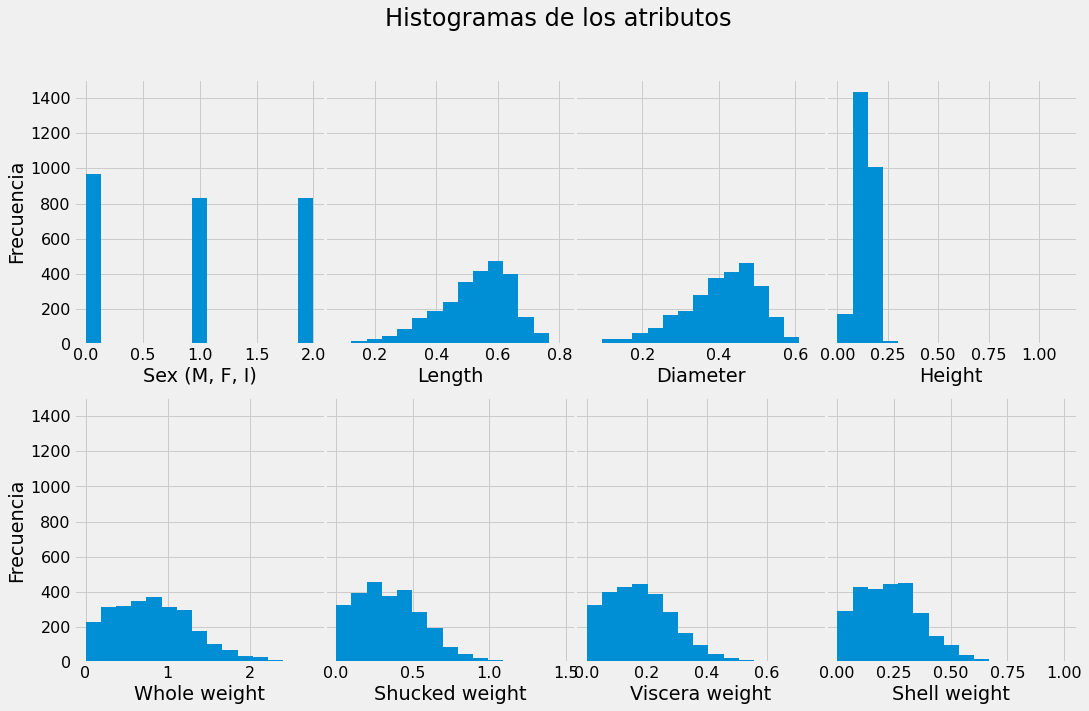

In [28]:
# al tener 8 atributos, generamos un canvas vacío de 2 filas por 4 columnas
figs, axs = plt.subplots(2,4, figsize=(16,10), sharey=True)

# generamos iterativamente las figuras
i = 0
for row in axs:
  for ax in row:
    # gráficamos cada histograma, utilizando 15 bins en c/u
    ax.hist(X_train[:,i], 15, density=False)
    # recuperamos el nombre de cada atributo
    ax.set_xlabel(feature_names[i][:-1])
    i+=1
axs[0,0].set_ylabel('Frecuencia')
axs[1,0].set_ylabel('Frecuencia')
#axs[1,0].set_yscale('log') # permite visualizar posibles outliers para 'Height'
plt.subplots_adjust(wspace=0)
figs.suptitle('Histogramas de los atributos', fontsize=24);

Es posible hacer algunas observaciones a partir del histograma: 
* La variable *Sex* muestra una cantidad relativamente similar de ejemplos por categoría.
* Todas las variables, excluyendo *Height*, se encuentran distribuidas a través de su rango de valores, pudiendo apreciar el rango en el que se encuentra la media de cada una de ellas.
* La variable *Height* parece contener outliers, dado que para sus valores más elevados registra una frecuencia muy baja de repetición (imperceptible en escala lineal, pudiendo apreciarlos en una logarítmica). 

Se relizan a continuación gráficos de dispersión, a modo de observar la relación existente entre atributos. Esto es importante, dada la similar naturaleza de los atributos relativos al tamaño y peso de los especímenes analizados.

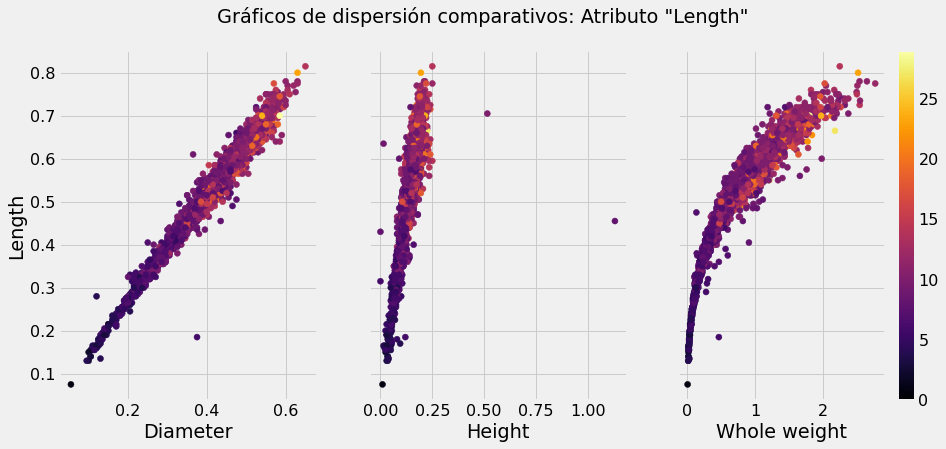

In [14]:
# ingresamos en una lista el atributo ppal., y una tupla con los secundarios 
# con los cuales comparamos
compare_vals = [1, (2, 3, 4)]

# generamos canvas de acuerdo a los gráficos de dispersión requeridos
figs, axs = plt.subplots(1, len(compare_vals[1]), sharey=True)
axs[0].set_ylabel(feature_names[compare_vals[0]][:-1])
figs.suptitle(f'Gráficos de dispersión comparativos: Atributo "{feature_names[compare_vals[0]][:-1]}"')
cm = plt.cm.get_cmap('inferno') # generamos colormap para mostrar las etiquetas

# generamos recursivamente los scatter plots
for i in range(len(compare_vals[1])):
  sc = axs[i].scatter(X_train[:,compare_vals[1][i]], X_train[:,compare_vals[0]],
                      c=y_train, vmin=0, vmax=np.max(y_train), cmap=cm)
  axs[i].set_xlabel(feature_names[compare_vals[1][i]][:-1])
plt.colorbar(sc);

Se ve una clara relación lineal entre los parámetros de tamaño (*Diameter*, *Height* y *Length*). Queda también más clara la existencia de outliers en *Height*.

Existe una correlación también con el peso (mayor tamaño, mayor peso), aunque esta no es completamente lineal.

Repetimos esta operación para los atributos relativos al peso.

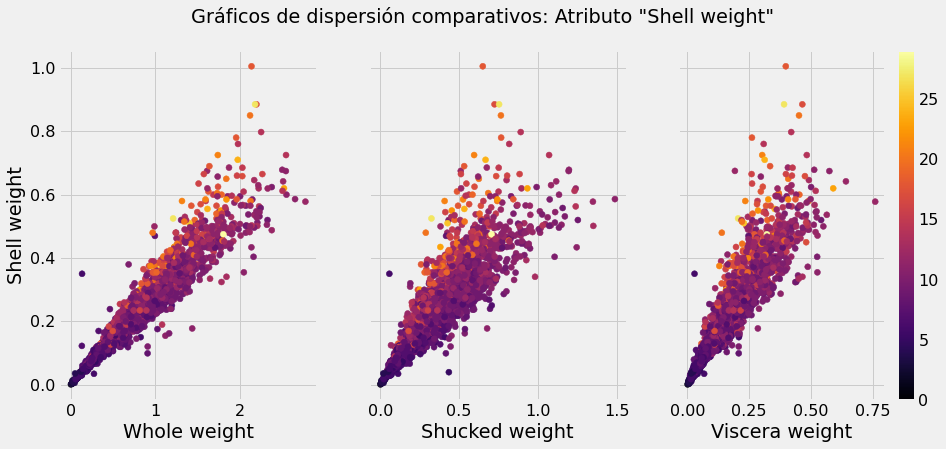

In [15]:
# ingresamos en una lista el atributo ppal., y una tupla con los secundarios 
# con los cuales comparamos
compare_vals = [7, (4, 5, 6)]

# generamos canvas de acuerdo a los gráficos de dispersión requeridos
figs, axs = plt.subplots(1, len(compare_vals[1]), sharey=True)
axs[0].set_ylabel(feature_names[compare_vals[0]][:-1])
figs.suptitle(f'Gráficos de dispersión comparativos: Atributo "{feature_names[compare_vals[0]][:-1]}"')
cm = plt.cm.get_cmap('inferno') # generamos colormap para mostrar las etiquetas

# generamos recursivamente los plots
for i in range(len(compare_vals[1])):
  sc = axs[i].scatter(X_train[:,compare_vals[1][i]], X_train[:,compare_vals[0]],
                      c=y_train, vmin=0, vmax=np.max(y_train), cmap=cm)
  axs[i].set_xlabel(feature_names[compare_vals[1][i]][:-1])
plt.colorbar(sc);

Se observa también una clara correlación de los parámetros de peso.

En ambos gráficos presentados, podemos ver la relación que se establece entre atributos y etiquetas. A pesar de que esta no es completamente clara, es posible ver que los especímenes de menor peso y tamaño son de menor edad, lo que resulta lógico.

Por otro lado, es interesante ver que los especímenes de mayor edad, en cuanto al peso, suelen tener un mayor valor relativo del peso de su concha. Es decir, para el mismo peso, respecto a cualquiera de los otros tres atributos, los de mayor edad suelen ser de mayor *Shell weight*.

# 5 - Procesamiento de los datos

Por lo visto previamente, se sabe que existe una correlación importante entre atributos, a pesar de esto no se determina obviar ninguno, dado que la cantidad de atributos total es pequeña. Se recomienda a futuro hacer un análisis sobre el funcionamiento de un algoritmo de clasificación/regresión con la inclusión de solo ciertos atributos, respecto a la inclusión de la totalidad.

Se busca eliminar los outliers vistos en el atributo *Height*, y luego realizar una estandarización de los atributos, excluyendo al categórico *Sex*.

In [16]:
def idx_outliers(x, m=3):
  return np.where(abs(x - np.mean(x)) > m*np.std(x))[0]

outliers_train = idx_outliers(X_train[:,3])

X_train_mod = np.delete(X_train, outliers_train, axis= 0)
y_train_mod = np.delete(y_train, outliers_train, axis=0)

print(f'Se eliminan {X_train.shape[0]-X_train_mod.shape[0]} ejemplos por contener outliers.')

Se eliminan 4 ejemplos por contener outliers.


Una vez eliminados los outliers en el set de entrenamiento, repetimos el gráfico de dispersión presentado previamente.

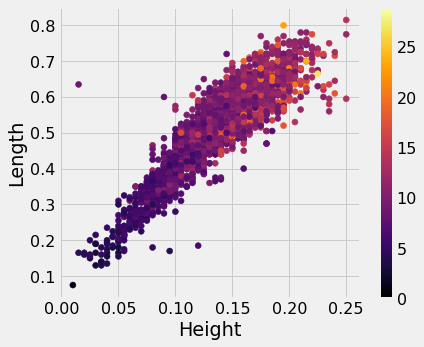

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
cm = plt.cm.get_cmap('inferno') # generamos colormap para mostrar las etiquetas
sc = ax.scatter(X_train_mod[:,3], X_train_mod[:,1], c=y_train_mod, vmin=0, 
                vmax=np.max(y_train_mod), cmap=cm)
ax.set_ylabel(feature_names[1][:-1])
ax.set_xlabel(feature_names[3][:-1])
plt.colorbar(sc);

A continuación, se procede a estandarizar los datos, con el cuidado de realizar este proceso a partir de los valores medios, y de desvío estándar, que se obtienen para el set de entrenamiento.

In [18]:
# calculamos la media y el desvío para los atributos (exluyendo el sexo)
mean = np.mean(X_train_mod[:,1:], axis=0)
std = np.std(X_train_mod[:,1:], axis=0)

# aplicamos estandarización
X_train_mod[:,1:] = (X_train_mod[:,1:] - mean)/std

print(f'Media y desvío estándar para el set de entrenamiento, \
luego de la estandarización de valores.')
print(f'Medias:           {np.mean(X_train_mod, axis=0)}')
print(f'Desvíos estándar: {np.std(X_train_mod, axis=0)}\n')

# repetimos el procesamiento aplicado sobre los sets de validación y prueba
# eliminación de outliers
outliers_test = idx_outliers(X_test[:,3])
outliers_val = idx_outliers(X_val[:,3])

X_test_mod = np.delete(X_test, outliers_test, axis= 0)
y_test_mod = np.delete(y_test, outliers_test, axis=0)
X_val_mod = np.delete(X_val, outliers_val, axis= 0)
y_val_mod = np.delete(y_val, outliers_val, axis=0)

print(f'Se eliminan {X_test.shape[0]-X_test_mod.shape[0]} ejemplos del set de prueba con outliers.')
print(f'Se eliminan {X_val.shape[0]-X_val_mod.shape[0]} ejemplos del set de validación con outliers.')

# aplicamos estandarización
X_test_mod[:,1:] = (X_test_mod[:,1:] - mean)/std
X_val_mod[:,1:] = (X_val_mod[:,1:] - mean)/std

Media y desvío estándar para el set de entrenamiento, luego de la estandarización de valores.
Medias:           [ 0.95  0.   -0.   -0.   -0.    0.   -0.   -0.  ]
Desvíos estándar: [0.83 1.   1.   1.   1.   1.   1.   1.  ]

Se eliminan 1 ejemplos del set de prueba con outliers.
Se eliminan 0 ejemplos del set de validación con outliers.


Es posible a futuro la realización de un pipeline de procesamiento en una función, que incluya la eliminación de outliers y la estandarización.

A continuación, se repiten algunos histogramas previamente presentados para los sets estandarizados y sin outliers. Se muestra también un círculo cuyo radio es equivalente a tres devíos estándar.

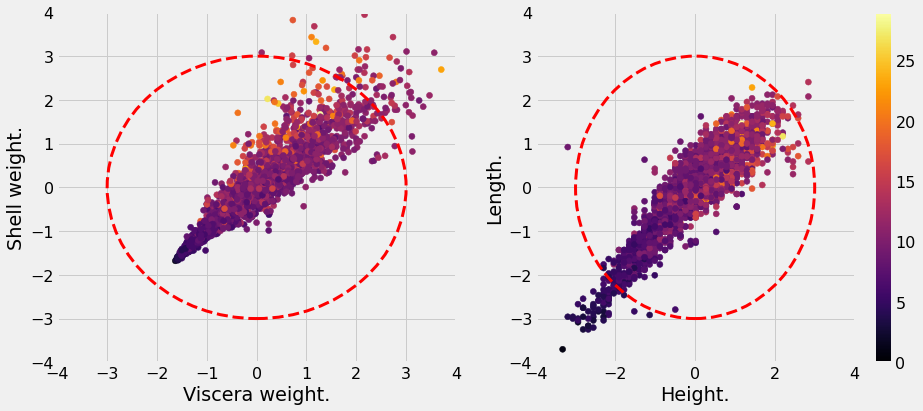

In [19]:
figs, axs = plt.subplots(1,2)

# creamos una listas con los índices para generar los scatter plots
vals = [(6,7), (3,1)]

cm = plt.cm.get_cmap('inferno') # generamos colormap para mostrar las etiquetas
# creamos los scatter plots
axs[0].scatter(X_train_mod[:,vals[0][0]], X_train_mod[:,vals[0][1]], 
               c=y_train_mod, vmin=0, vmax=np.max(y_train_mod), cmap=cm)
axs[1].scatter(X_train_mod[:,vals[1][0]], X_train_mod[:,vals[1][1]], 
               c=y_train_mod, vmin=0, vmax=np.max(y_train_mod), cmap=cm)
# mostramos círculos de radio 3 (equivalente a 3 veces el desvío estándar)
circle0 = plt.Circle((0,0), 3, ls='--', lw=3, color='r', fill=False)
circle1 = plt.Circle((0,0), 3, ls='--', lw=3, color='r', fill=False)
axs[0].add_artist(circle0)
axs[1].add_artist(circle1)
# generamos las leyendas, ajustamos y colocamos el colormap
axs[0].set_xlabel(feature_names[vals[0][0]])
axs[0].set_ylabel(feature_names[vals[0][1]])
axs[1].set_xlabel(feature_names[vals[1][0]])
axs[1].set_ylabel(feature_names[vals[1][1]])
axs[0].set_xlim(-4, 4)
axs[0].set_ylim(-4, 4)
axs[1].set_xlim(-4, 4)
axs[1].set_ylim(-4, 4)
plt.colorbar(sc);

Como vemos, la gran mayoría de ejemplos se encuentran dentro de los tres desvíos estándar, respecto a la media (0).

# 6 - Consideraciones

Se obtienen finalmente tres sets para entrenar, ajustar, probar y testear el algoritmo a entrenar. Se obtienen por separados los tres sets tal como se separan del dataset original, y los mismos con procesamiento aplicado (estandarizacióin y eliminación de outliers). Realizamos algunas consideraciones:

- Será importante ver si mejora el modelo (y cuánto) con el preprocesamiento aplicado, teniendo en cuenta que el dataset elegido no tiene grandes variaciones en las escalas de representación numérica de los atributos. 
- De obtener mejores resultados con el dataset modificado (preprocesado), se puede crear una función pipeline que procese los datos a la entrada. Esto será importante, por ejemplo, para poder realizar k-fold cross validation.
- En vez de eliminar los ejemplos con outliers, y dado que se observa una clara correlación entre parámetros, se puede reemplazar el valor considerado inválido por una estimación numérica basada en la regresión de atributos.
- En este caso, a pesar de la correlación entre atributos, no se decide eliminar ninguno dado que no hay una cantidad muy grande. Podrá evaluarse luego con qué atributos se obtienen modelos que arrojen mejores resultados.